## [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I)

`E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2*.`

Constraint is to stay within the same parameter count (~11.8k) and number of iterations (200k).

| model          | train loss | val loss    |
|----------------|------------|-------------|
| * base         |      2.122 |       2.164 |
| ^ improved lrd |      2.095 |       2.150 |
| " block_size=4 |      2.126 |       2.173 |


*&ast; losses for the reproduced model are slightly lower.* </br>
*^ Improved learning rate decay:* `lr = 0.175 - 0.165*i/num_steps`. </br>
*\"* `block_size=4` *and* `hidden_size=170` *(preserving param count)* </br>

Got the better result with different learning rate decay.

`E02: I was not careful with the intialization of the network in this video. E02.1 What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? E02.2 Can you tune the initialization to get a starting loss that is much more similar to E02.1?`

When initializing the weights from normal distribution one should normalize (divide) them by `sqrt(nin)` where `nin` is the number of inputs to the layer. This way multiplying inputs and weights that are both from normal distribution one gets variance 1 in the resulting activations of each neuron. This means that at the end of the network the returned logits have the variance approx. 1 and therefor probs (resulting from `Softmax` or in calculating `CrossEntropy`) are more uniformey distributed resulting in lower negative log likelyhood loss.

Teoretical loss with uniform probs: $loss = -log(1/27) = 3.296$. </br>
Before normalization: `tr_loss=23.862`. </br>
After normalization: `tr_loss=3.752` (much closer to the theoreticsal loss with uniform probs).

`E03: Read the `[`Bengio et al 2003 paper`](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)`, implement and try any idea from the paper. Did it work?`
Read it breifly but no improvement ideas caught my attention.



In [130]:
import os
import requests
import random
import math

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['axes.axisbelow'] = True
%matplotlib inline

### Dataset

In [131]:
data_dir = './data'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

In [132]:
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
fname = url.split('/')[-1]
fpath = os.path.join(data_dir, fname)
if not os.path.isfile(fpath):
    resp = requests.get(url)
    with open(fpath, 'w') as f:
        f.write(resp.text)

In [133]:
with open(fpath, 'r') as f:
    words = f.read().splitlines()

len(words), words[:5]

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [134]:
SEP_TOK = '.'
vocab = [SEP_TOK] + sorted(list(set(''.join(words))) )
stoi  = {s: i for i, s in enumerate(vocab)}
itos  = {i: s for i, s in enumerate(vocab)}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [135]:
block_size = 4

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [stoi[SEP_TOK]] * block_size
        for ch in word + SEP_TOK:
            ix = stoi[ch]
            # print(f'{"".join(itos[ch] for ch in context)} ---> {itos[ix]}')
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [136]:
random.seed(42)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

random.shuffle(words)
X, Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([228146, 4]) torch.Size([228146])
torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


### Model

In [54]:
n_embed = 10
hidden_size = 170
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(vocab), n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, len(vocab)), generator=g)
b2 = torch.randn(len(vocab), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters), [p.shape for p in parameters]

(11857,
 [torch.Size([27, 10]),
  torch.Size([40, 170]),
  torch.Size([170]),
  torch.Size([170, 27]),
  torch.Size([27])])

In [55]:
# training setup
batch_size = 32

for p in parameters:
    p.requires_grad = True

In [56]:
losses = []
step_count = 0

In [57]:
num_steps = 200_000
for i in tqdm(range(num_steps), 'Training'):
    # get minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb = Xtr[ix]
    Yb = Ytr[ix]

    # forward pass
    emb = C[Xb].view((Xb.shape[0]), block_size*n_embed)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.175 - 0.165*i/num_steps
    for p in parameters:
        p.data += -lr*p.grad

    # stats
    step_count += 1
    losses.append(loss.log10().item())

print(loss.item())

Training: 100%|██████████| 200000/200000 [02:39<00:00, 1253.98it/s]

2.4603769779205322


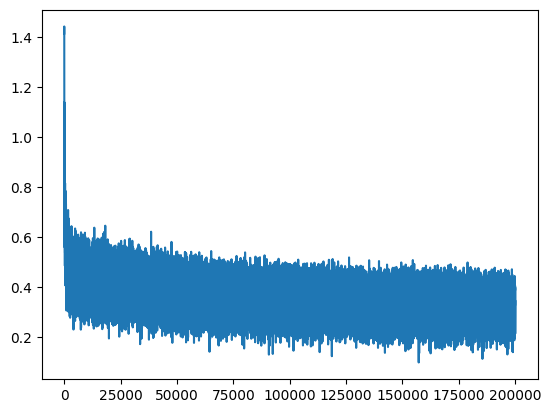

In [58]:
plt.plot(torch.arange(step_count), losses)

In [59]:
# evaluating on the train split
emb = C[Xtr].view((Xtr.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1264, grad_fn=<NllLossBackward0>)

In [60]:
# evaluating on the dev split
emb = C[Xdev].view((Xdev.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1725, grad_fn=<NllLossBackward0>)

### Sampling from the model

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [stoi[SEP_TOK]]*block_size
    while True:
        emb = C[torch.tensor(context)].view(1, block_size*n_embed)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        if ix == stoi[SEP_TOK]:
            break
        out.append(itos[ix])
        context = context[1:] + [ix]
    print(''.join(out))

junide
janasid
parlay
adin
kai
rito
cassaretz
samela
zamilena
jadbiainroik
las
jaicayla
ter
nomuntsyn
demmerconne
waqhuan
rhose
yar
ocely
jamilyn


### Improving params initialization

In [125]:
# Teoretical init loss with uniform probs
prob = 1/27
prob, -math.log(prob)

(0.037037037037037035, 3.295836866004329)

In [138]:
n_embed = 10
hidden_size = 170
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(vocab), n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, hidden_size), generator=g) / math.sqrt(n_embed * block_size)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, len(vocab)), generator=g) / hidden_size
b2 = torch.randn(len(vocab), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters), [p.shape for p in parameters]

(11857,
 [torch.Size([27, 10]),
  torch.Size([40, 170]),
  torch.Size([170]),
  torch.Size([170, 27]),
  torch.Size([27])])

In [143]:
# evaluating on the train split
emb = C[Xtr].view((Xtr.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.7571)

In [140]:
emb[0].var()
h[0].var()
logits[0].var()

tensor(0.8207)

In [141]:
print(f'{logits[0]=}')
counts = logits[0].exp()
print(f'{counts=}')
probs = counts / counts.sum()
print(f'{probs=}')
loss = -probs[Ydev[0]].log()
loss

logits[0]=tensor([ 0.4859, -0.7969, -0.4385,  0.1294, -0.1759,  0.0632, -1.4143,  0.0339,
        -0.8796, -0.6838, -1.2161,  0.6225, -1.2004, -0.2850, -0.9180, -0.9976,
         0.6515, -0.8042,  1.4037,  2.4110, -0.5919,  0.2786,  0.2582, -0.5169,
        -1.8414, -0.7856, -0.6394])
counts=tensor([ 1.6256,  0.4507,  0.6450,  1.1381,  0.8387,  1.0653,  0.2431,  1.0345,
         0.4149,  0.5047,  0.2964,  1.8635,  0.3011,  0.7520,  0.3993,  0.3688,
         1.9185,  0.4474,  4.0702, 11.1456,  0.5533,  1.3213,  1.2945,  0.5963,
         0.1586,  0.4558,  0.5276])
probs=tensor([0.0472, 0.0131, 0.0187, 0.0331, 0.0244, 0.0309, 0.0071, 0.0300, 0.0121,
        0.0147, 0.0086, 0.0541, 0.0087, 0.0218, 0.0116, 0.0107, 0.0557, 0.0130,
        0.1182, 0.3237, 0.0161, 0.0384, 0.0376, 0.0173, 0.0046, 0.0132, 0.0153])


tensor(4.3359)

In [142]:
# evaluating on the dev split
emb = C[Xdev].view((Xdev.shape[0]), block_size*n_embed)
h = torch.tanh(emb @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(3.7525)

### Visualising embeddings

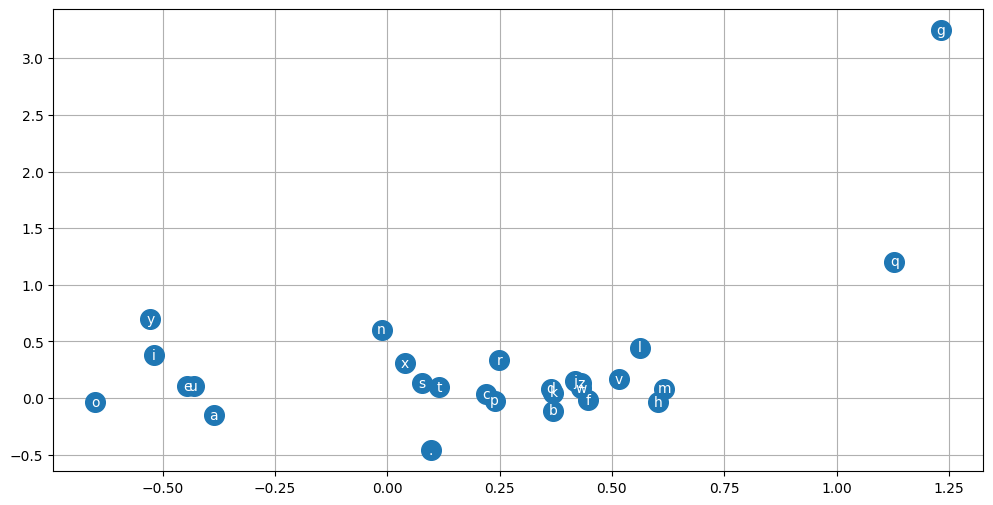

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(C.data[:, 0], C.data[:, 1], s=200)
for i, ch in enumerate(vocab):
    plt.text(C[i, 0].item(), C[i, 1].item(), s=ch, ha='center', va='center', color='white')

plt.grid()

### Searching for good lr

In [ ]:
n_embed = 2
hidden_size = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(vocab), n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, len(vocab)), generator=g)
b2 = torch.randn(len(vocab), generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters), [p.shape for p in parameters]

(3481,
 [torch.Size([27, 2]),
  torch.Size([6, 100]),
  torch.Size([100]),
  torch.Size([100, 27]),
  torch.Size([27])])

In [ ]:
for p in parameters:
    p.requires_grad = True

batch_size = 32
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [ ]:
losses = []
for i in range(1000):
    # get minibatch
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb = X[ix]
    Yb = Y[ix]
    # forward pass
    emb = C[Xb].view((Xb.shape[0]), block_size*n_embed)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    losses.append(loss.item())

In [ ]:
min_losses, ixs = torch.topk(torch.tensor(losses), k=5, largest=False)
min_lrs = [lrs[ix].item() for ix in ixs]
print(min_losses)
print(ixs)
print(min_lrs)

tensor([2.4670, 2.5409, 2.5633, 2.6289, 2.6827])
tensor([698, 692, 749, 837, 753])
[0.12476595491170883, 0.11969555914402008, 0.1775207817554474, 0.3262222111225128, 0.18249930441379547]


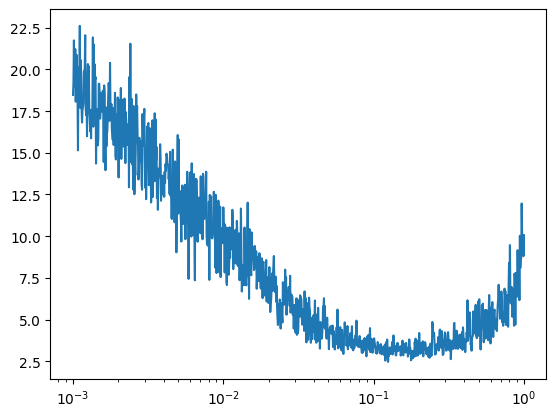

In [ ]:
plt.plot(lrs.tolist(), losses)
plt.xscale('log')

In [ ]:
window_span = 10
smooth_losses = []
for i in range(len(losses)):
    start = max(0, i - window_span)
    end = min(len(losses), i + window_span + 1)
    new_loss = sum(losses[start:end]) / len(losses[start:end])
    smooth_losses.append(new_loss)

In [ ]:
min_losses, ixs = torch.topk(torch.tensor(smooth_losses), k=5, largest=False)
min_lrs = [lrs[ix].item() for ix in ixs]
print(min_losses)
print(ixs)
print(min_lrs)

tensor([3.0971, 3.1110, 3.1137, 3.1249, 3.1259])
tensor([746, 745, 747, 694, 750])
[0.17387622594833374, 0.17267808318138123, 0.17508269846439362, 0.1213623657822609, 0.17875254154205322]


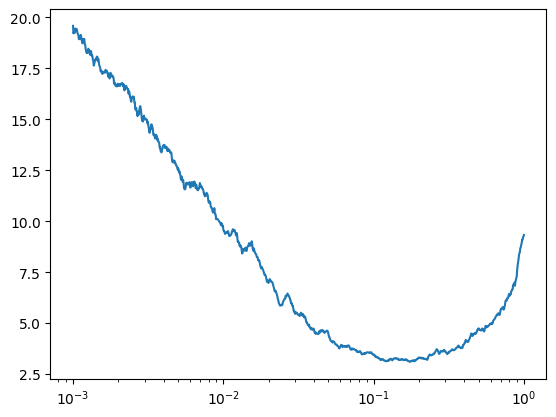

In [ ]:
plt.plot(lrs.tolist(), smooth_losses)
plt.xscale('log')